[View in Colaboratory](https://colab.research.google.com/github/mattwang44/Research_Simulation/blob/master/0727.ipynb)

# Knowing all variables → verify the balancing

In [0]:
#!kill -9 -1

In [0]:
import sympy as sp
from scipy.optimize import fsolve  
import numpy as np
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

In [0]:
DOF=4

####### P.-Y. Lin ####### 
# size
l = [0.127, 0.757, 0.140, 0];
s = [0.127, 0.378, 0.140, 0];
m = [4.55, 11.42, 42.60, 0];
MP_PY = np.array([l, s, m])

#             s = [ang_type, k,    a,    b,    i, j]
SP_PY = np.array([[1,        1000, .491, .119, 1, 4], 
                  [4,        600,  .127, .198, 2, 4], 
                  [4,        8000, .010, .151, 1, 3]])

# ang_type: (alpha,beta)
#        1: (pi,   0)   
#        2: (0,    pi)  
#        3: (0,    0)
#        4: (pi,   pi)



####### Y.-Y. Lee ####### 
# size
l = [0.09, 0.09, 0.06, 0];
s = [0.18, 0.18, 0.07, 0];
m = [.848, .848, 1.33, 0];
MP_YY = np.array([l, s, m])



In [0]:
# G-SBM
def GSBM(MP):
  l,s,m = MP[0,:],MP[1,:],MP[2,:]
  DOF = MP.shape[1]
  mat = np.zeros((DOF+1,DOF+1,2,2))
  g = 9.80665
  for i in range(DOF):
    mat[0,i+1,:,:] = np.eye(2)*g*(-1)*(s[i]*m[i]+l[i]*np.sum(m[i+1:]))
  return mat
  
gsbm = GSBM(MP_PY)

In [0]:
# rotation matix
def rot(ang): 
  #angle in radian
  return np.array([[np.cos(ang),-np.sin(ang)],[np.sin(ang),np.cos(ang)]])

In [0]:
## Known spring variables, get ESBM
def ESBM_single_spring(sp, MP):
  # sp = [ang_type, k,    a, b, i, j]
  alpha = np.pi if sp[0]==1 or sp[0]==4 else 0
  beta  = np.pi if sp[0]==2 or sp[0]==4 else 0
  k, a, b, prox, dist, = sp[1],sp[2],sp[3],sp[4],sp[5]
  l,s,m = MP[0,:],MP[1,:],MP[2,:]
  
  DOF = MP.shape[1]  #prox=1, dist=DOF+1, n=1+4, mat is n-by-n
  mat = np.zeros((DOF+1,DOF+1,2,2))
  for i in range(DOF+1):
    for j in range(DOF+1):
      if i ==j:
        if i == prox-1:
          mat[i,j] = k*a*a*rot(0)
          continue
        elif i == dist-1:
          mat[i,j] = k*b*b*rot(0)
          continue
        else:
          mat[i,j] = k*l[i-1]*l[i-1]*rot(0)
          continue
      if i > j or i+1<prox or j+1>dist:
        continue
      elif i==prox-1 and j==dist-1:
        mat[i,j] = -k*a*b*rot(beta-alpha)
        continue
      elif i==prox-1:
        mat[i,j] = rot(-alpha)*(-k*a*l[j-1])
        continue
      elif j==dist-1:
        mat[i,j] = rot(beta)*k*b*l[i-1]
        continue   
      else:
        mat[i,j] = rot(0)*k*l[i-1]*l[j-1]
  return mat

def ESBM(SP, MP):
  DOF = MP.shape[1]  
  mat = np.zeros((DOF+1,DOF+1,2,2))
  for n in range(SP.shape[0]):
    mat = mat + ESBM_single_spring(SP[n,:], MP)
  return mat

#print(ESBM(SP_PY, MP_PY))

In [0]:
def sum_SBM(SP, MP):
  return GSBM(MP)+ESBM(SP, MP)

In [0]:
def trans(mat):
  n = mat.shape[0]
  matrix = np.zeros((n*2,n*2))
  for i in range(n):
    for j in range(n):
      matrix[i*2:i*2+2, j*2:j*2+2] = mat[i,j,:,:]
  return matrix

In [84]:
#residual potential energy: 
def residual(SP, MP):
  #   Ec: constant potential energy after balancing
  #   Eo: should be close to zero if balanced
  res_stf = trans(sum_SBM(SP, MP))

  
  
  Ec = res_stf.sum()/4
  
  Eo = Ec - res_stf.diagonal().sum()/4
  
  
  return Ec, Eo

print(residual(SP_PY, MP_PY))

(845.8065435612499, 0.5619435612499046)


# SOLVE a, b

solving the attachment length with minimized value of customized cost function

In [0]:
## unknown spring variables, solve them



#             s = [ang_type, k,    i, j]
SP_PY_unk = np.array([[1,    1000, 1, 4], 
                      [4,    600,  2, 4], 
                      [4,    8000, 1, 3]])



In [0]:
# ESBM containing symbolic variables (of single spring)
def ESBM_single_spring_var(spv, MP):
  # spv = [ang_type, k,    a, b, i, j]
  alpha = np.pi if spv[0]==1 or spv[0]==4 else 0
  beta  = np.pi if spv[0]==2 or spv[0]==4 else 0
  k, a, b, prox, dist, = spv[1],spv[2],spv[3],spv[4],spv[5]
  l,s,m = MP[0,:],MP[1,:],MP[2,:]
  
  DOF = MP.shape[1]  #prox=1, dist=DOF+1, n=1+4, mat is n-by-n
  mat = Matrix(np.zeros(((DOF+1)*2,(DOF+1)*2)))
  for i in range(DOF+1):
    for j in range(DOF+1):
      if i >= j or i+1<prox or j+1>dist:
        continue
      elif i==prox-1 and j==dist-1:
        mat[i*2:i*2+2,j*2:j*2+2] = -k*a*b*rot(beta-alpha)
        continue
      elif i==prox-1:
        mat[i*2:i*2+2,j*2:j*2+2] = rot(-alpha)*(-k*a*l[j-1])
        continue
      elif j==dist-1:
        mat[i*2:i*2+2,j*2:j*2+2] = rot(beta)*k*b*l[i-1]
        continue   
      else:
        mat[i*2:i*2+2,j*2:j*2+2] = rot(0)*k*l[i-1]*l[j-1]
  return mat

# ESBM containing symbolic variables (summation ESBM for all springs given)
def ESBM_var(SPv, MP):
  DOF = MP.shape[1]  
  mat = Matrix(np.zeros(((DOF+1)*2,(DOF+1)*2)))
  for n in range(SPv.shape[0]):
    mat = mat + ESBM_single_spring_var(SPv[n,:], MP)
  return mat

# Derive balancing equations from given variables of 
# springs (k & attachment angle type) & manipulator(l, s, m)
def Eqs(SPv, MP, p=False):
  sum_SBM = trans(GSBM(MP)) + ESBM_var(SPv, MP)
  if p:
    print(sum_SBM)
  n = int(sum_SBM.shape[0]/2)
  eqs_list = []
  for i in range(n):
    for j in range(i+1,n):
      eqs_list = eqs_list + [sum_SBM[i*2+1,j*2+1]]
  return eqs_list

In [0]:
from sympy import symbols, Matrix, Transpose
from sympy.solvers import solve

a1, b1 = symbols('a1 b1')
a2, b2 = symbols('a2 b2')
a3, b3 = symbols('a3 b3')
a4, b4 = symbols('a4 b4')
a5, b5 = symbols('a5 b5')
a6, b6 = symbols('a6 b6')

k1, k2, k3, k4, k5, k6 = 8000, 6000, 2000, 1000, 600, 400

In [62]:
# DOF=1, n=2
l = [0.127];
s = [0.06];
m = [4.55];
MP = np.array([l, s, m])
SPv = Matrix(np.array([[1,        k1,   a1,   b1,   1, 2]]))
eqs = Eqs(SPv, MP)
for eq in eqs:
  print(eq)
  
solve(eqs)


8000.0*a1*b1 - 2.67721545


[{a1: 0.00033465193125/b1}]

In [63]:
# DOF=2, n=3
l = [0.127, 0.757];
s = [0.06, 0.378];
m = [4.55, 11.42];
MP = np.array([l, s, m])

# ang_type: (alpha,beta)
#        1: (pi,   0)   
#        2: (0,    pi)  
#        3: (0,    0)
#        4: (pi,   pi)
k1, k2, k3, k4, k5, k6 = 8000, 4000, 2000, 1000, 600, 400

sp1 = np.array([[1,        k1,   a1,   b1,   1, 3],
                [2,        k2,   a2,   b2,   2, 3]]) # 1

sp2 = np.array([[2,        k1,   a1,   b1,   1, 3],
                [1,        k2,   a2,   b2,   1, 2],
                [1,        k3,   a3,   b3,   2, 3]])

sp3 = np.array([[1,        k1,   a1,   b1,   1, 3],
                [2,        k2,   a2,   b2,   1, 3]]) 

sp4 = np.array([[1,        k1,   a1,   b1,   1, 3],
                [4,        k2,   a2,   b2,   1, 3],
                [3,        k3,   a3,   b3,   1, 2]]) # 2

sp5 = np.array([[1,        k1,   a1,   b1,   1, 3],
                [3,        k2,   a2,   b2,   1, 3],
                [3,        k3,   a3,   b3,   2, 3]]) # 2

sp6 = np.array([[2,        k1,   a1,   b1,   1, 3],
                [3,        k2,   a2,   b2,   1, 3],
                [1,        k3,   a3,   b3,   1, 2]]) # 2

# a1, b1 = 2, 2   #designated value
sp7 = np.array([[2,        k1,   a1,   b1,   1, 3],
                [4,        k2,   a2,   b2,   1, 3],
                [1,        k3,   a3,   b3,   2, 3]]) # 2

SPv = Matrix(sp7)  # change configuration here
eqs = Eqs(SPv, MP)
for eq in eqs:
  print(eq)
print()
solve(eqs)

-1016.0*a1 + 508.0*a2 - 16.900192211
8000.0*a1*b1 - 4000.0*a2*b2 - 42.332954454
2000.0*a3*b3 - 1016.0*b1 - 508.0*b2



[{a1: 3.86088582677165e-10*(43083500.0*b2 + 13705713.0)/(b1 - b2),
  a2: 7.72177165354331e-10*(43083500.0*b1 + 13705713.0)/(b1 - b2),
  a3: 0.254*(2.0*b1 + b2)/b3}]

In [64]:
# DOF=3, n=4

# simulation of PY-Lin's paper9 (2012)
# l = [0.127, 0.757, 0.140];
# s = [0.127, 0.378, 0.140];
# m = [4.55, 11.42, 42.60];

l = [0.240, 0.757, 0.280];
s = [0.150, 0.200, 0.240];
m = [10.80,  15.00, 30.00];
MP = np.array([l, s, m])
k1, k2, k3 = 1000,600,4000
sp1 = Matrix(np.array([[1,        k1,   a1,   b1,   1, 4],
                       [4,        k2,   a2,   b2,   2, 4],
                       [4,        k3,   a3,   b3,   1, 3]]))   

eqs = Eqs(sp1, MP)
for eq in eqs:
  print(eq)
  
print()
solve(eqs)

240.0*a1 + 960.0*a3 - 121.798593
757.0*a1 - 4000.0*a3*b3 - 252.1289715
1000.0*a1*b1 - 70.60788
454.2*a2 - 960.0*b3 + 181.68
-600.0*a2*b2 + 240.0*b1
757.0*b1 - 454.2*b2



[{a1: 0.382900732529723,
  a2: 0.240000000000000,
  a3: 0.0311483512425694,
  b1: 0.184402572263345,
  b2: 0.307337620438909,
  b3: 0.302800000000000}]

# SOLVE k, a, b

solving the spring coefficient & attachment length with minimized value of customized cost function

In [0]:
## unknown spring variables, solve them



#             s = [ang_type, k,    i, j]
SP_PY_unk = np.array([[1,    1000, 1, 4], 
                      [4,    600,  2, 4], 
                      [4,    8000, 1, 3]])



In [0]:
from sympy import symbols, Matrix, Transpose
from sympy.solvers import solve

a1, b1 = symbols('a1 b1')
a2, b2 = symbols('a2 b2')
a3, b3 = symbols('a3 b3')
a4, b4 = symbols('a4 b4')
a5, b5 = symbols('a5 b5')
a6, b6 = symbols('a6 b6')

k1, k2, k3, k4, k5, k6 = symbols('k1 k2 k3 k4 k5 k6')

In [67]:
# DOF=1, n=2
l = [0.127];
s = [0.06];
m = [4.55];
MP = np.array([l, s, m])
SPv = Matrix(np.array([[1,        k1,   a1,   b1,   1, 2]]))
eqs = Eqs(SPv, MP)
for eq in eqs:
  print(eq)
  
solve(eqs)


1.0*a1*b1*k1 - 2.67721545


[{a1: 2.67721545/(b1*k1)}]

In [68]:
# DOF=2, n=3
l = [0.127, 0.757];
s = [0.06, 0.378];
m = [4.55, 11.42];
MP = np.array([l, s, m])

# ang_type: (alpha,beta)
#        1: (pi,   0)   
#        2: (0,    pi)  
#        3: (0,    0)
#        4: (pi,   pi)

sp1 = np.array([[1,        k1,   a1,   b1,   1, 3],
                [2,        k2,   a2,   b2,   2, 3]]) # 1

sp2 = np.array([[2,        k1,   a1,   b1,   1, 3],
                [1,        k2,   a2,   b2,   1, 2],
                [1,        k3,   a3,   b3,   2, 3]])

sp3 = np.array([[1,        k1,   a1,   b1,   1, 3],
                [2,        k2,   a2,   b2,   1, 3]]) 

sp4 = np.array([[1,        k1,   a1,   b1,   1, 3],
                [4,        k2,   a2,   b2,   1, 3],
                [3,        k3,   a3,   b3,   1, 2]]) # 2

sp5 = np.array([[1,        k1,   a1,   b1,   1, 3],
                [3,        k2,   a2,   b2,   1, 3],
                [3,        k3,   a3,   b3,   2, 3]]) # 2

sp6 = np.array([[2,        k1,   a1,   b1,   1, 3],
                [3,        k2,   a2,   b2,   1, 3],
                [1,        k3,   a3,   b3,   1, 2]]) # 2

# a1, b1 = 2, 2   #designated value
sp7 = np.array([[2,        k1,   a1,   b1,   1, 3],
                [4,        k2,   a2,   b2,   1, 3],
                [1,        k3,   a3,   b3,   2, 3]]) # 2

SPv = Matrix(sp7)  # change configuration here
eqs = Eqs(SPv, MP)
for eq in eqs:
  print(eq)
print()
solve(eqs)

-0.127*a1*k1 + 0.127*a2*k2 - 16.900192211
1.0*a1*b1*k1 - 1.0*a2*b2*k2 - 42.332954454
1.0*a3*b3*k3 - 0.127*b1*k1 - 0.127*b2*k2



[{a1: 3.08870866141732e-6*(43083500.0*b2 + 13705713.0)/(k1*(b1 - b2)),
  a2: 3.08870866141732e-6*(43083500.0*b1 + 13705713.0)/(k2*(b1 - b2)),
  a3: 0.127*(b1*k1 + b2*k2)/(b3*k3)}]

In [69]:
# DOF=3, n=4
l = [0.127, 0.757, 0.140];
s = [0.127, 0.378, 0.140];
m = [4.55, 11.42, 42.60];

MP = np.array([l, s, m])
# k1, k2, k3 = 1000,600,8000
sp1 = Matrix(np.array([[1,        k1,   a1,   b1,   1, 4],
                       [4,        k2,   a2,   b2,   2, 4],
                       [4,        k3,   a3,   b3,   1, 3]]))   # simulation of PY-Lin (2012)

eqs = Eqs(sp1, MP)
for eq in eqs:
  print(eq)
  
print()
solve(eqs)

0.127*a1*k1 + 0.127*a3*k3 - 72.9456872935
0.757*a1*k1 - 1.0*a3*b3*k3 - 358.579764984
1.0*a1*b1*k1 - 58.4868606
0.757*a2*k2 - 0.127*b3*k3 + 0.096139*k1
-1.0*a2*b2*k2 + 0.127*b1*k1
0.757*b1*k1 - 0.757*b2*k2



[{a1: 0.000129546235138705*(4433749.0*k1 + 4433749.0*k2 + 3656496.0*k3)/(k1*(k1 + k2 + k3)),
  a2: 0.127000000000000,
  a3: 100.690199900264/(k1 + k2 + k3),
  b1: 451474.8*(k1 + k2 + k3)/(4433749.0*k1 + 4433749.0*k2 + 3656496.0*k3),
  b2: 451474.8*k1*(k1 + k2 + k3)/(k2*(4433749.0*k1 + 4433749.0*k2 + 3656496.0*k3)),
  b3: 0.757*(k1 + k2)/k3}]

# PLOT


## functions needed



In [0]:
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

# trajectory (angles)
traj_PY = np.array([[282, 8, 81],  [247,293,343], [314,78+360,140+360]]) /180*np.pi;
traj_YY = np.array([[135, 0, 270], [90, 0, 270],  [90, 45, 90]])         /180*np.pi;
# SP_PY = np.array([[1,        1000, .491, .119, 1, 4], 
#                   [4,        600,  .127, .198, 2, 4], 
#                   [4,        8000, .010, .151, 1, 3]])

In [0]:
def MPplot(MP, SP, traj, p=True, plot=False):
  color = "rbmcy"
  DOF = MP.shape[1]
  l,s = MP[0,:], MP[1,:]
  timestamp = traj.shape[0]
  if plot:
    f, ax = plt.subplots(2,3, sharex=True, sharey=True, figsize=(20,12))
  area_sum = 0
  for t in range(timestamp):
    # manipulator
    x = np.cumsum(np.array([0]+[np.cos(traj[t,i])*l[i] for i in range(DOF)]))
    y = np.cumsum(np.array([0]+[np.sin(traj[t,i])*l[i] for i in range(DOF)]))
    
    #springs
    attpt = []
    for n in range(SP.shape[0]):
      sp = SP[n,:]
      ang_type, k, a, b, i, j = sp[0], sp[1], sp[2], sp[3], int(sp[4]), int(sp[5])
      if k==0:
        continue
      alpha = np.pi if ang_type==1 or ang_type==4 else 0
      beta  = np.pi if ang_type==2 or ang_type==4 else 0
      angp = np.pi*3/2 if i == 1 else traj[t,i-2]
      angd = traj[t,j-2]
      sp_prox = np.dot(np.array(rot(alpha)), np.array([[np.cos(angp)*a],[np.sin(angp)*a]])) + np.array([[x[i-1]],[y[i-1]]])
      sp_dist = np.dot(rot(beta),  np.array([[np.cos(angd)*b],[np.sin(angd)*b]])) + np.array([[x[j-2]],[y[j-2]]])
      attpt = attpt + [sp_prox.T[0], sp_dist.T[0]]
      # springs
      if plot:
        ax[int(t/3),t%3].plot([sp_prox[0],sp_dist[0]], [sp_prox[1],sp_dist[1]], color[n%5]+'--')
        ax[int(t/3),t%3].plot([sp_prox[0],sp_dist[0]], [sp_prox[1],sp_dist[1]], color[n%5]+'o')
      # prolonged link
      if plot:
        if i == 1:
          ax[int(t/3),t%3].plot([sp_prox[0],0], [sp_prox[1],0], 'k--')
        ax[int(t/3),t%3].plot([sp_prox[0],x[i-1]], [sp_prox[1],y[i-1]], 'k--')
        ax[int(t/3),t%3].plot([sp_dist[0],x[j-2]], [sp_dist[1],y[j-2]], 'k--')
      
    # convex hull
    rjoint = np.concatenate(([x],[y]), axis=0).T[0:-1,:]
    attpt = np.array(attpt)
    points = np.concatenate((rjoint,attpt), axis=0)
    hull = ConvexHull(points)
    if plot:
      for simplex in hull.simplices:
        ax[int(t/3),t%3].plot(points[simplex, 0], points[simplex, 1], 'g-')
      ax[int(t/3),t%3].text(.5, .75, "area="+str(hull.area), fontsize=12)    
      ax[int(t/3),t%3].plot(x, y, 'k')
      ax[int(t/3),t%3].plot(x[0:-1], y[0:-1], 'ko')
      ax[int(t/3),t%3].axis('equal')
      ax[int(t/3),t%3].axis([-0.75,1.3,-1.1,0.95])
    area_sum += hull.area
  if p:
    print("avg. spanning area=",area_sum/timestamp) 
  return area_sum/timestamp
  



## SOLVE
avg. spanning area= 0.5462935665720939

[240.0*a1 + 1920.0*a3 - 121.798593, 757.0*a1 - 8000.0*a3*b3 - 252.1289715, 1000.0*a1*b1 - 70.60788, 378.5*a2 - 1920.0*b3 + 181.68, -500.0*a2*b2 + 240.0*b1, 757.0*b1 - 378.5*b2]
{a1: 0.360605070587673, a2: 0.240000000000000, a3: 0.0183611333640409, b1: 0.195803902271622, b2: 0.391607804543244, b3: 0.141937500000000}
avg. spanning area= 2.885066512362666


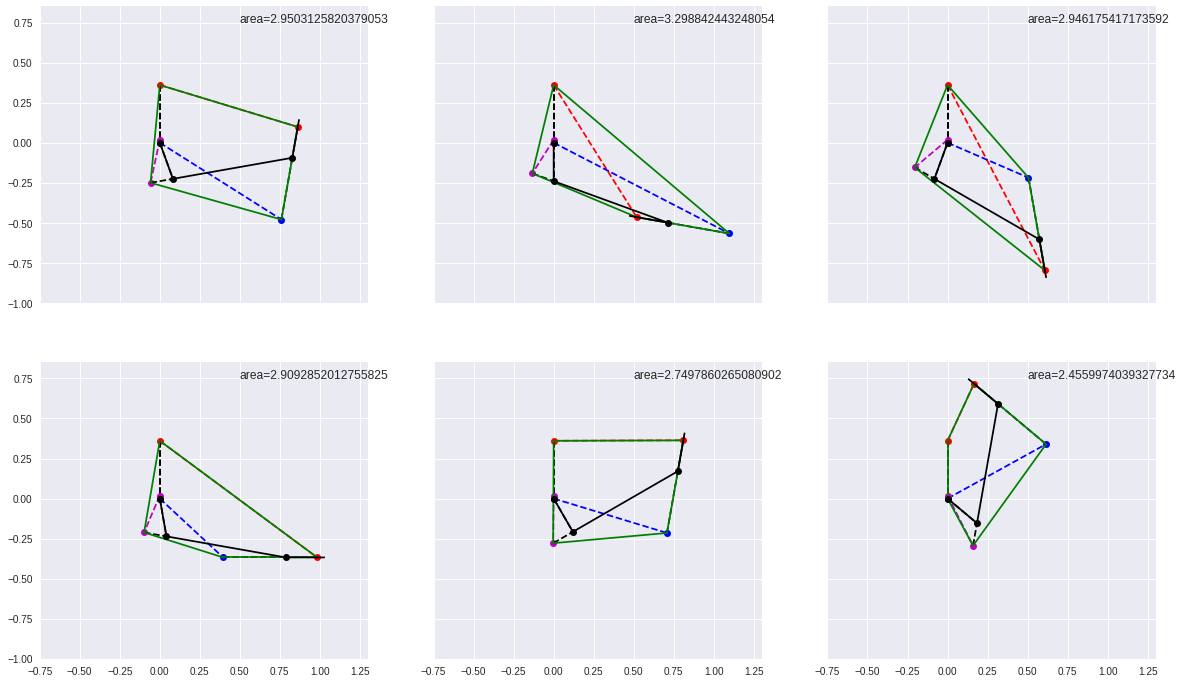

In [72]:
# original parameters (avg. spanning area= 0.44341427984615556)
# k1, k2, k3 = 1000,600,4000
# sp1 = Matrix(np.array([[1,        k1,   a1,   b1,   1, 4],
#                        [4,        k2,   a2,   b2,   2, 4],
#                        [4,        k3,   a3,   b3,   1, 3]]))  

l = [0.240, 0.757, 0.240];
s = [0.150, 0.200, 0.240];
m = [10.80,  15.00, 30.00];
MP = np.array([l, s, m])
a1, b1, a2, b2, a3, b3, a4, b4, a5, b5, a6, b6 = symbols('a1 b1 a2 b2 a3 b3 a4 b4 a5 b5 a6 b6')

k1, k2, k3 = 1500,1200,2500
k1, k2, k3 = 2000,1800,5000
k1, k2, k3 = 1000,500,8000
sp1 = Matrix(np.array([[1,        k1,   a1,   b1,   1, 4],
                       [4,        k2,   a2,   b2,   2, 4],
                       [4,        k3,   a3,   b3,   1, 3]]))   
eqs = Eqs(sp1, MP)
solve(eqs)
print(eqs)
r = solve(eqs)[0]
print(r)

for key,val in r.items():
  exec(str(key) + '=val')
  
SP = np.array([[1,        k1,   a1,   b1,   1, 4],
               [4,        k2,   a2,   b2,   2, 4],
               [4,        k3,   a3,   b3,   1, 3]])
#print(residual(SP, MP), "newton (max.) of residual potential energy after balancing")

# trajectory (angles)
traj = np.array([[290, 10, 80], [270,340,170], [250,330,280], [280,350,360], [300,390,440], [320,80+360,140+360]]) / 180*np.pi;

space = MPplot(MP, SP, traj, True, True)
#plt.close()
#2.885

In [89]:
a1=0.360605070587673
a2=0.240000000000000
a3=0.0183611333640409
b1=0.195803902271622
b2=0.391607804543244
b3=0.141937500000000

k1, k2, k3 = 1000,500,8000
 
SP = np.array([[1,        k1,   a1,   b1,   1, 4],
               [4,        k2,   a2,   b2,   2, 4],
               [4,        k3,   a3,   b3,   1, 3]])
l = [0.240, 0.757, 0.240];
s = [0.150, 0.200, 0.240];
m = [10.80,  15.00, 30.00];
MP = np.array([l, s, m])
print(residual(SP, MP))

(1152.647051182611, 0.0)


## SOLVE - minimizing spanning space

{a2: 0.240000000000000, a3: 0.0205676971875000, a4: 0.0602878244937417, b1: 0.205882352941176, b3: 0.0454968071519794}
avg. spanning area= 2.4328678829640027


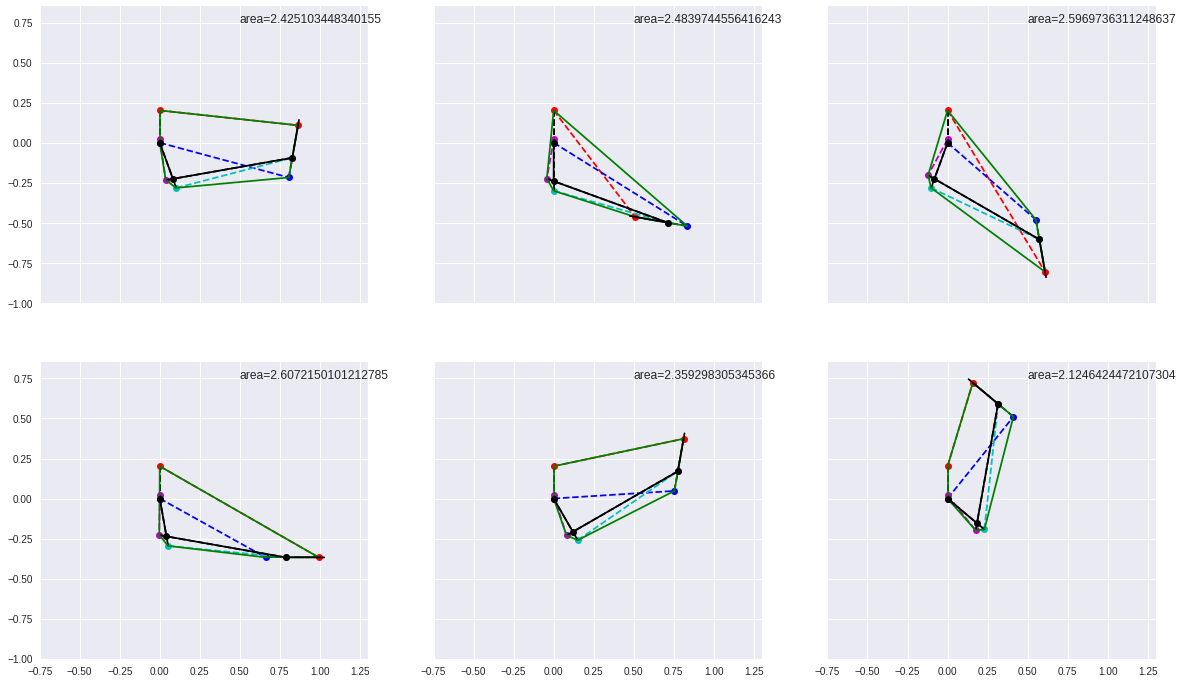

In [73]:
# original parameters (avg. spanning area= 0.44341427984615556)
# k1, k2, k3 = 1000,600,4000
# sp1 = Matrix(np.array([[1,        k1,   a1,   b1,   1, 4],
#                        [4,        k2,   a2,   b2,   2, 4],
#                        [4,        k3,   a3,   b3,   1, 3]]))  
#color = "rbmcy"
l = [0.240, 0.757, 0.240];
s = [0.150, 0.200, 0.240];
m = [10.80,  15.00, 30.00];
MP = np.array([l, s, m])
a1, b1, a2, b2, a3, b3, a4, b4, a5, b5, a6, b6 = symbols('a1 b1 a2 b2 a3 b3 a4 b4 a5 b5 a6 b6')
b2 = 0.125
a1 = 0.2017368
# b1 = 0.205882352941176/2
# b3 = 0.0454968071519794
p=1.5

k1, k2, k3, k4,k5,k6 = 1700,2800,8000, 16000, 1700.0*(p-1)*0, 1700.0*(2*p-2)*0
# dict = {a2: 0.240000000000000, a3: 0.0205676971875000, a4: 0.0602878244937417, b1: 0.205882352941176, b3: 0.0454968071519794}

# for key,val in dict.items():
#   exec(str(key) + '=val')
sp1 = Matrix(np.array([[1,        k1,   a1,   b1,   1, 4],
                       [4,        k2,   a2,   b2,   2, 4],
                       [4,        k3,   a3,   b3,   1, 3],
                       [3,        k4,   a4,   .757, 2, 3],
                       [4,        k5,   a1,   b4,   1, 3],
                       [3,        k6,   a6,   .24,  1, 2]]))  

# sp1 = Matrix(np.array([[1,        k1,   a1,   b1,   1, 4],
#                        [4,        k2,   a2,   b2,   2, 4],
#                        [4,        k3,   a3,   b3,   1, 3],
#                        [3,        k4,   a4,   .757,  2, 3]]))  

eqs = Eqs(sp1, MP)
#solve(eqs)
r = solve(eqs)[0]
print(r)

for key,val in r.items():
  exec(str(key) + '=val')

SP =         np.array([[1,        k1,   a1,   b1,   1, 4],
                       [4,        k2,   a2,   b2,   2, 4],
                       [4,        k3,   a3,   b3,   1, 3],
                       [3,        k4,   a4,   .757, 2, 3],
                       [4,        k5,   a1,   b4,   1, 3],
                       [3,        k6,   a6,   .24,  1, 2]])
#print(residual(SP, MP), "newton (max.) of residual potential energy after balancing")

# trajectory (angles)
traj = np.array([[290, 10, 80], [270,340,170], [250,330,280], [280,350,360], [300,390,440], [320,80+360,140+360]]) / 180*np.pi;



space = MPplot(MP, SP, traj, True, True)
#plt.close()

{a1: 0.201736800000000, a2: 0.240000000000000, a3: 0.0205676971875000, a4: 0.108191882995828, b1: 0.0686274509803922, b3: 0.0454968071519796}
avg. spanning area= 2.336906156962814


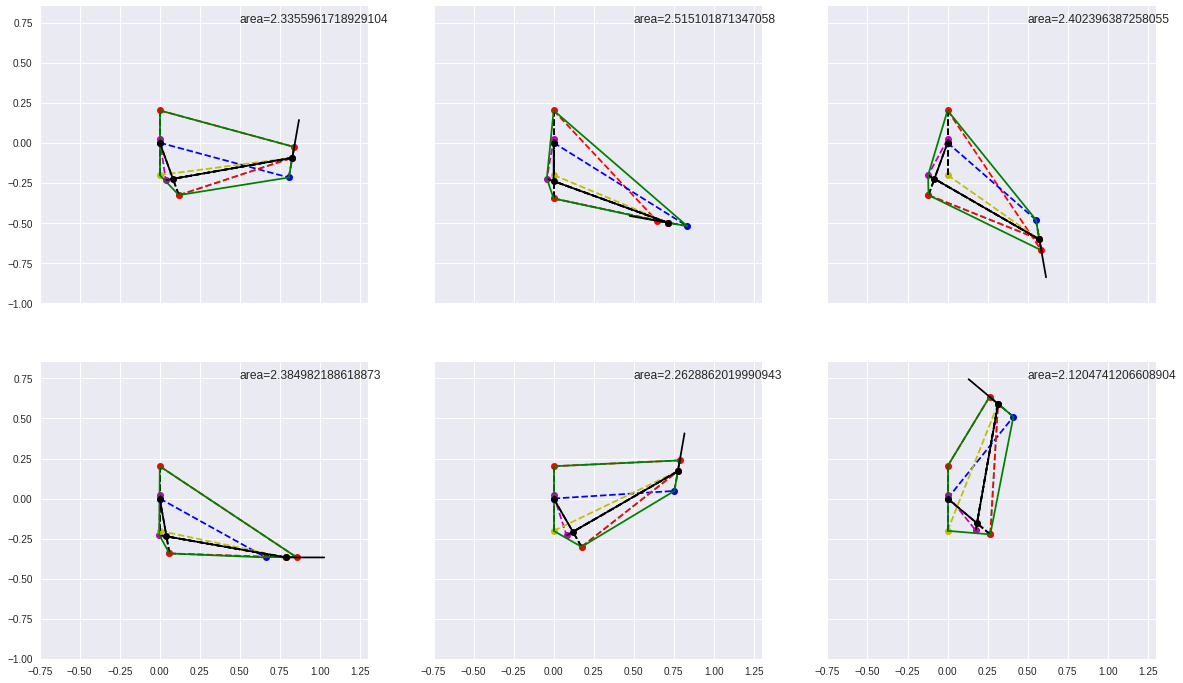

In [74]:
# original parameters (avg. spanning area= 0.44341427984615556)
# k1, k2, k3 = 1000,600,4000
# sp1 = Matrix(np.array([[1,        k1,   a1,   b1,   1, 4],
#                        [4,        k2,   a2,   b2,   2, 4],
#                        [4,        k3,   a3,   b3,   1, 3]]))  

l = [0.240, 0.757, 0.240];
s = [0.150, 0.200, 0.240];
m = [10.80,  15.00, 30.00];
MP = np.array([l, s, m])
a1, b1, a2, b2, a3, b3, a4, b4, a5, b5, a6, b6, b7 = symbols('a1 b1 a2 b2 a3 b3 a4 b4 a5 b5 a6 b6 b7')
b2 = 0.125
p=1.5*2
# a1 = 0.2017368

# b1 = 0.205882352941176/p
# b3 = 0.0454968071519794


k1, k2, k3, k4, k5, k6 = 1700, 2800, 8000, 2*8000, 1700.0*(p-1)*0, 1700.0*(2*p-2)*10*0
k1, k2, k3, k4, k5, k6 = 1700*p, 2800, 8000, 2*8000, 1700.0*(p-1), 8000#1700.0*(2*p-2)*1

# dict = {a2: 0.240000000000000, a3: 0.0205676971875000, a4: 0.0602878244937417, b1: 0.205882352941176, b3: 0.0454968071519794}
#        {a2: 0.112747535314286, a3: 0.0205676971875000, a4: 0.0436237981737417, b1: 0.205882352941176, b3: 0.0454968071519794, a6: 0.0320960784313725}

# for key,val in dict.items():
#   exec(str(key) + '=val')
# a6 = 0.03
sp1 = Matrix(np.array([[1,        k1,   a1,   b1,   1, 4],
                       [4,        k2,   a2,   b2,   2, 4],
                       [4,        k3,   a3,   b3,   1, 3],
                       [3,        k4,   a4,   .757, 2, 3],
                       [3,        k5,   a1,   .757, 1, 3],
                       [3,        k6,   a4,   .757, 2, 3]]))  

# sp1 = Matrix(np.array([[1,        k1,   a1,   b1,   1, 4],
#                        [4,        k2,   a2,   b2,   2, 4],
#                        [4,        k3,   a3,   b3,   1, 3],
#                        [3,        k4,   a4,   .757,  2, 3]]))  

eqs = Eqs(sp1, MP)
#solve(eqs)
r = solve(eqs)[0]
print(r)

for key,val in r.items():
  exec(str(key) + '=val')
#color = "rbmcy"
# {a1: 0.201736800000000, a2: 0.240000000000000, a3: 0.0205676971875000, a4: 0.108191882995828, b1: 0.0686274509803922, b3: 0.0454968071519796}
SP =         np.array([[1,        k1,   a1,   b1,   1, 4],
                       [4,        k2,   a2,   b2,   2, 4],
                       [4,        k3,   a3,   b3,   1, 3],
                       [3,        k4,   a4,   .757, 2, 3],
                       [3,        k5,   a1,   .757, 1, 3],
                       [3,        k6,   a4,   .757, 2, 3]])
#print(residual(SP, MP), "newton (max.) of residual potential energy after balancing")

# trajectory (angles)
traj = np.array([[290, 10, 80], [270,340,170], [250,330,280], [280,350,360], [300,390,440], [320,80+360,140+360]]) / 180*np.pi;

space = MPplot(MP, SP, traj, True, True)
#plt.close()

#2.337



In [88]:
a1= 0.201736800000000
a2=0.240000000000000
a3=0.0205676971875000
a4=0.108191882995828
b1= 0.0686274509803922
b3= 0.0454968071519796

b2 = 0.125
p=1.5*2
k1, k2, k3, k4, k5, k6 = 1700*p, 2800, 8000, 2*8000, 1700.0*(p-1), 8000 #1700.0*(2*p-2)*1


SP =         np.array([[1,        k1,   a1,   b1,   1, 4],
                       [4,        k2,   a2,   b2,   2, 4],
                       [4,        k3,   a3,   b3,   1, 3],
                       [3,        k4,   a4,   .757, 2, 3],
                       [3,        k5,   a1,   .757, 1, 3],
                       [3,        k6,   a4,   .757, 2, 3]])
l = [0.240, 0.757, 0.240];
s = [0.150, 0.200, 0.240];
m = [10.80,  15.00, 30.00];
MP = np.array([l, s, m])
print(residual(SP, MP))

(12818.802795005764, -1.8189894035458565e-12)


{a1: 0.222042247027741, a2: 0.0610169491525424, a3: -0.104658460175033, b1: 0.211995332555426, b2: -0.211995332555426, b4: 0.156876546091015}
avg. spanning area= 3.602211413537649


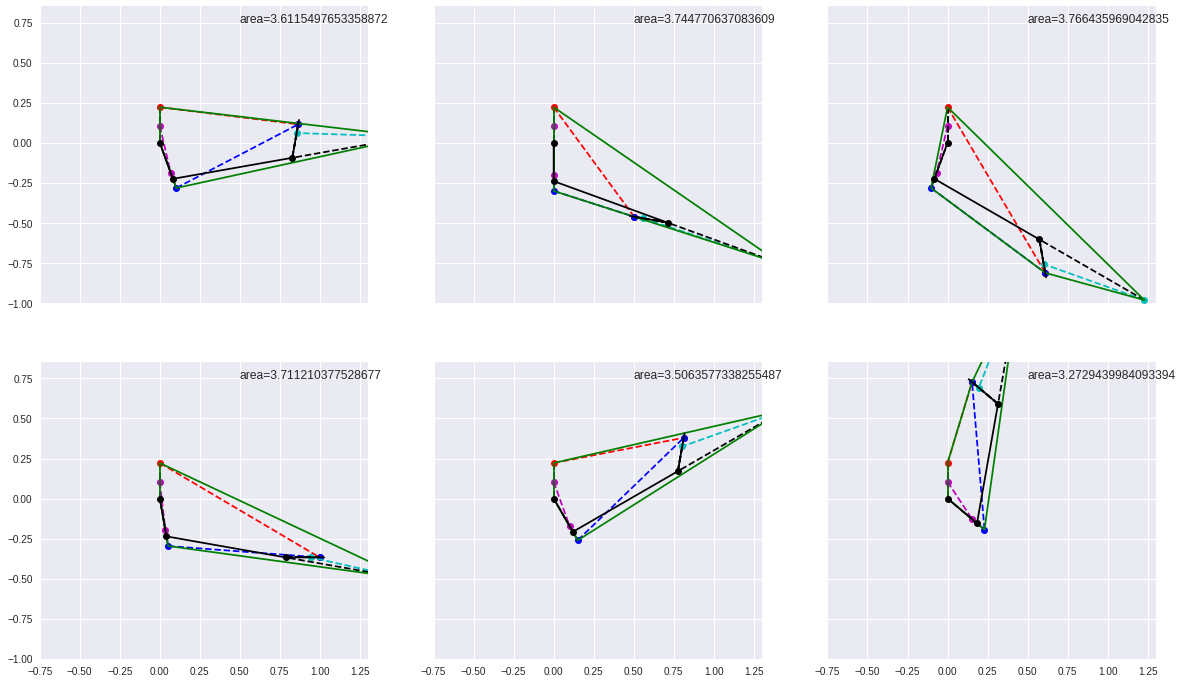

In [75]:
# original parameters (avg. spanning area= 0.44341427984615556)
# k1, k2, k3 = 1000,600,4000
# sp1 = Matrix(np.array([[1,        k1,   a1,   b1,   1, 4],
#                        [4,        k2,   a2,   b2,   2, 4],
#                        [4,        k3,   a3,   b3,   1, 3]]))  
#color = "rbmcy"
l = [0.240, 0.757, 0.240];
s = [0.150, 0.200, 0.240];
m = [10.80,  15.00, 30.00];
MP = np.array([l, s, m])
a1, b1, a2, b2, a3, b3, a4, b4, a5, b5, a6, b6 = symbols('a1 b1 a2 b2 a3 b3 a4 b4 a5 b5 a6 b6')
b3 = 0.2
k1, k2, k3, k4,k5 = 1500,5900,2000, 10000, 0
sp1 = Matrix(np.array([[1,        k1,   a1,   b1,   1, 4],
                       [2,        k2,   a2,   b2,   2, 4],
                       [3,        k3,   a3,   b3,   1, 2],
                       [3,        k4,   0.757,   b4,  3, 4]]))  

eqs = Eqs(sp1, MP)
solve(eqs)
r = solve(eqs)[0]
print(r)

for key,val in r.items():
  exec(str(key) + '=val')

SP         = np.array([[1,        k1,   a1,   b1,   1, 4],
                       [2,        k2,   a2,   b2,   2, 4],
                       [3,        k3,   a3,   b3,   1, 2],
                       [3,        k4,   0.757,   b4,  3, 4]])
#print(residual(SP, MP), "newton (max.) of residual potential energy after balancing")

# trajectory (angles)
traj = np.array([[290, 10, 80], [270,340,170], [250,330,280], [280,350,360], [300,390,440], [320,80+360,140+360]]) / 180*np.pi;

space = MPplot(MP, SP, traj, True, True)
#plt.close()

{a1: 0.252171000000000, a2: 0.240000000000000, a3: 0.0323990921897582, a4: -0.0404155194061948, b1: 0.164705882352941, b3: 0.280090000000000}
avg. spanning area= 2.765361337922372


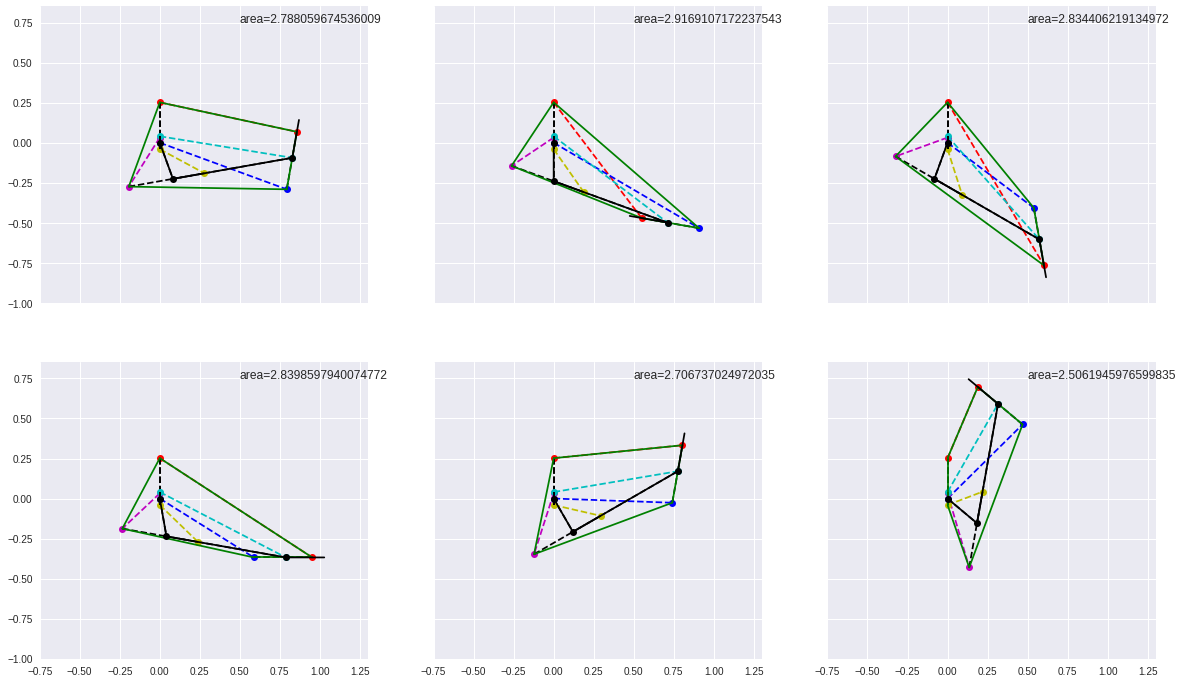

In [76]:
# original parameters (avg. spanning area= 0.44341427984615556)
# k1, k2, k3 = 1000,600,4000
# sp1 = Matrix(np.array([[1,        k1,   a1,   b1,   1, 4],
#                        [4,        k2,   a2,   b2,   2, 4],
#                        [4,        k3,   a3,   b3,   1, 3]]))  
#color = "rbmcy"
l = [0.240, 0.757, 0.240];
s = [0.150, 0.200, 0.240];
m = [10.80,  15.00, 30.00];
MP = np.array([l, s, m])
a1, b1, a2, b2, a3, b3, a4, b4, a5, b5, a6, b6 = symbols('a1 b1 a2 b2 a3 b3 a4 b4 a5 b5 a6 b6')
b2 = 0.2

k1, k2, k3, k4,k5 = 1700,1400,10000, 600, 8000
sp1 = Matrix(np.array([[1,        k1,   a1,   b1,   1, 4],
                       [4,        k2,   a2,   b2,   2, 4],
                       [4,        k3,   a3,   b3,   1, 3],
                       [3,        k4,   a4,   .757, 1, 3],
                       [1,        k5,   a4,   .2, 1, 2]]))  

eqs = Eqs(sp1, MP)
solve(eqs)
r = solve(eqs)[0]
print(r)

for key,val in r.items():
  exec(str(key) + '=val')

SP = np.array([[1,        k1,   a1,   b1,   1, 4],
               [4,        k2,   a2,   b2,   2, 4],
               [4,        k3,   a3,   b3,   1, 3],
               [3,        k4,   a4,   .757, 1, 3],
               [1,        k5,   a4,   .2, 1, 3]])
#print(residual(SP, MP), "newton (max.) of residual potential energy after balancing")

# trajectory (angles)
traj = np.array([[290, 10, 80], [270,340,170], [250,330,280], [280,350,360], [300,390,440], [320,80+360,140+360]]) / 180*np.pi;

space = MPplot(MP, SP, traj, True, True)
#plt.close()

## playground


In [77]:
# original parameters (avg. spanning area= 0.44341427984615556)
# k1, k2, k3 = 1000,600,4000
# sp1 = Matrix(np.array([[1,        k1,   a1,   b1,   1, 4],
#                        [4,        k2,   a2,   b2,   2, 4],
#                        [4,        k3,   a3,   b3,   1, 3]]))  

l = [0.240, 0.757, 0.240];
s = [0.150, 0.200, 0.240];
m = [10.80,  15.00, 30.00];
MP = np.array([l, s, m])
a1, b1, a2, b2, a3, b3, a4, b4, a5, b5, a6, b6 = symbols('a1 b1 a2 b2 a3 b3 a4 b4 a5 b5 a6 b6')

k1, k2, k3, k4,k5 = 2000,800,6000, 0, 0

b2 = 0.2
sp1 = Matrix(np.array([[1,        k1,   a1,   b1,   1, 4],
                       [2,        k2,   a2,   b2,   1, 4],
                       [1,        k3,   a3,   b3,   1, 3],
                       [1,        k4,   a4,   0.24, 1, 2],
                       [4,        k5,   0.24, b5,   2, 3]]))   
eqs = Eqs(sp1, MP)
solve(eqs)
print(eqs)
r = solve(eqs)[0]
print(r)

for key,val in r.items():
  exec(str(key) + '=val')
  
SP = np.array([[1,        k1,   a1,   b1,   1, 4],
               [2,        k2,   a2,   b2,   1, 4],
               [1,        k3,   a3,   b3,   1, 3],
               [1,        k4,   a4,   0.24, 1, 3],
               [4,        k5,   0.24, b5,   2, 3]])
#print(residual(SP, MP), "newton (max.) of residual potential energy after balancing")

# trajectory (angles)
traj = np.array([[290, 10, 80], [270,340,170], [250,330,280], [280,350,360], [300,390,440], [320,80+360,140+360]]) / 180*np.pi;

space = MPplot(MP, SP, traj)
#plt.close()

[480.0*a1 - 192.0*a2 + 1440.0*a3 - 121.798593, 1514.0*a1 - 605.6*a2 + 6000.0*a3*b3 - 252.1289715, 2000.0*a1*b1 + 160.0*a2 - 70.60788, 1440.0*b3 + 508.704, 480.0*b1 - 38.4, 1514.0*b1 - 121.12]
{a1: 0.264858381828315, a2: 0.176440868171685, a3: 0.0198216780634532, b1: 0.0800000000000000, b3: -0.353266666666667}
avg. spanning area= 2.793617118441279
